In [3]:
import os
import cv2

# Paths
input_root = './data_Shiuly_Night_jasmine'
output_root = './boxed_leaves'
os.makedirs(output_root, exist_ok=True)

# Function to process and draw bounding boxes
def process_image(image):
    # Convert to grayscale and blur to reduce noise
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blur, 50, 150)


    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]

    if large_contours:
        for cnt in large_contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    elif contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image

# Loop over each subfolder (class)
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    output_class_path = os.path.join(output_root, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    print(f"🔍 Processing class: {class_name}")

    image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    for filename in image_files:  # Process all images in each class
        img_path = os.path.join(class_path, filename)
        image = cv2.imread(img_path)
        if image is None:
            print(f" Could not read {filename}")
            continue

        processed_image = process_image(image)

        # Save the processed image with bounding box
        out_path = os.path.join(output_class_path, filename)
        cv2.imwrite(out_path, processed_image)

print("✅ All images processed and saved with bounding boxes!")

🔍 Processing class: multiple
🔍 Processing class: rust
🔍 Processing class: healthy
✅ All images processed and saved with bounding boxes!


 Showing samples for class: multiple


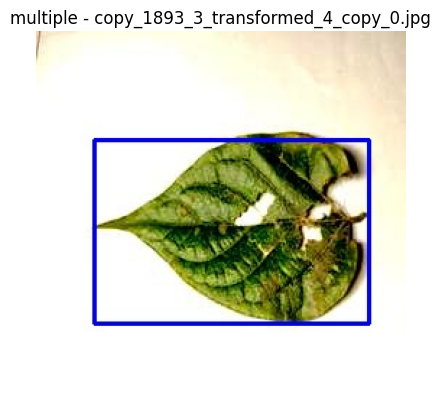

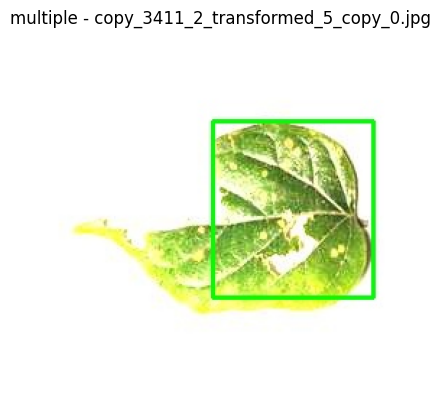

 Showing samples for class: rust


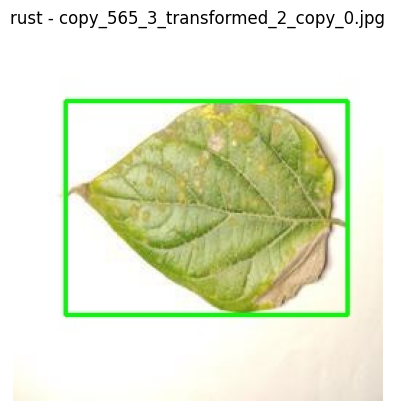

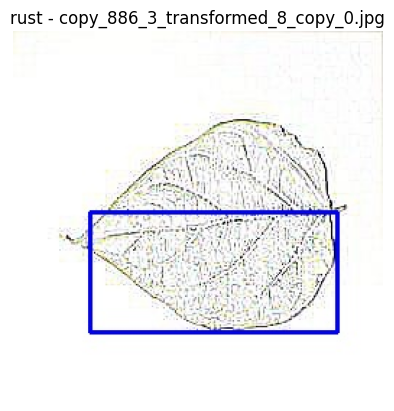

 Showing samples for class: healthy


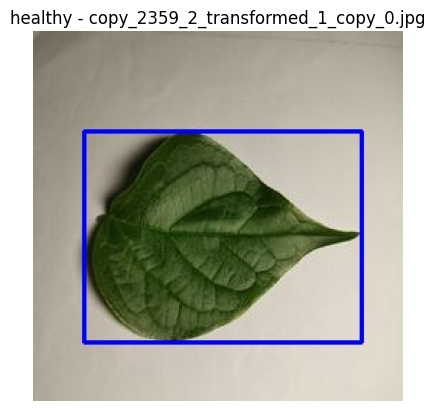

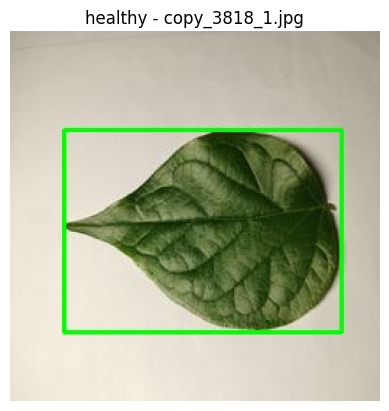

In [7]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Number of samples to show per class
samples_per_class = 2
output_root = './boxed_leaves'

def show_image(img_path, title=''):
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Loop through classes
for class_name in os.listdir(output_root):
    class_path = os.path.join(output_root, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = sorted([
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    # Randomly sample some images from the class
    sample_files = random.sample(image_files, min(samples_per_class, len(image_files)))
    print(f" Showing samples for class: {class_name}")

    for filename in sample_files:
        img_path = os.path.join(class_path, filename)
        show_image(img_path, title=f"{class_name} - {filename}")

In [8]:
import os

root_dir = './boxed_leaves'
total_images = 0

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    image_count = len([
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    total_images += image_count
    print(f" {class_name}: {image_count} images")

print(f"\n Total images: {total_images}")

 multiple: 4000 images
 rust: 4000 images
 healthy: 4000 images

 Total images: 12000


In [10]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Path to boxed leaf dataset
input_root = './boxed_leaves'
img_size = 224
batch_size = 32
epochs = 10

# Image augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    input_root,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    input_root,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# CNN model definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)

# Save model
model.save('cnn_finetuned_on_boxed_leaves.h5')
print(" CNN model training complete and saved.")

Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5290 - loss: 0.9362

/home/vrathik/jas/flask/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 250ms/step - accuracy: 0.5294 - loss: 0.9354 - val_accuracy: 0.8675 - val_loss: 0.3314
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.8610 - loss: 0.3383 - val_accuracy: 0.9379 - val_loss: 0.1736
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9303 - loss: 0.1892 - val_accuracy: 0.9629 - val_loss: 0.1072
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 246ms/step - accuracy: 0.9556 - loss: 0.1216 - val_accuracy: 0.9671 - val_loss: 0.0766
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9636 - loss: 0.1162 - val_accuracy: 0.9821 - val_loss: 0.0593
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9720 - loss: 0.0856 - val_accuracy: 0.9829 - val_loss: 0.0562
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.9794 - loss: 0.0629 - val_accuracy: 0.9946 - val_loss: 0.0305
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 248ms/step - accuracy: 0.9814 - loss: 0.0560 - val

 CNN model training complete and saved.


['healthy', 'multiple', 'rust']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


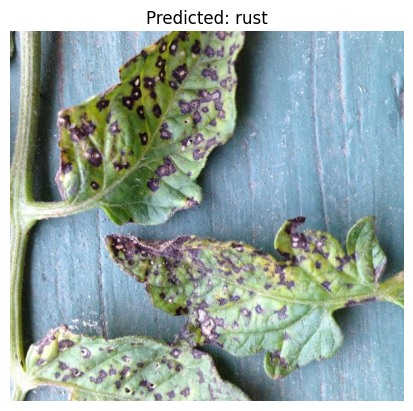

In [12]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_finetuned_on_boxed_leaves.h5')

# Set image parameters
img_size = 224
class_names = list(train_generator.class_indices.keys())  # Get class labels from training generator

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)
    print(class_names)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
predict_image('./1.jpg')  # Replace with actual image path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


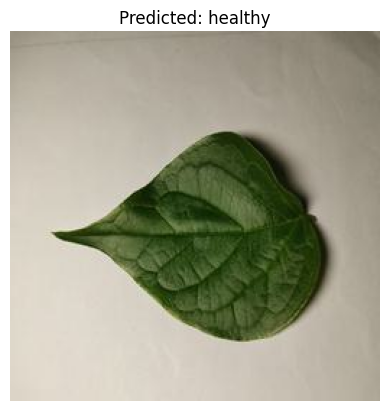

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_finetuned_on_boxed_leaves.h5')

# Set image parameters
img_size = 224
class_names = list(train_generator.class_indices.keys())  # Get class labels from training generator

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
predict_image('/content/image2.jpg')  # Replace with actual image path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


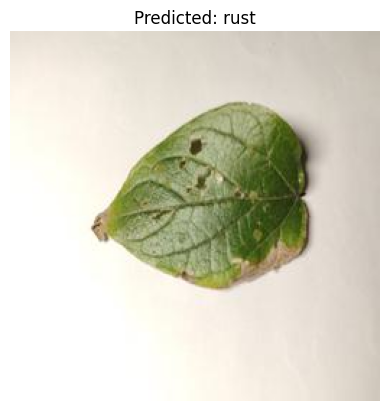

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_finetuned_on_boxed_leaves.h5')

# Set image parameters
img_size = 224
class_names = list(train_generator.class_indices.keys())  # Get class labels from training generator

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
predict_image('/content/image3.jpg')  # Replace with actual image path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


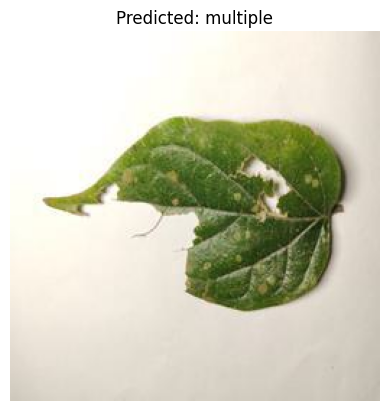

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_finetuned_on_boxed_leaves.h5')

# Set image parameters
img_size = 224
class_names = list(train_generator.class_indices.keys())  # Get class labels from training generator

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
predict_image('/content/image4.jpg')  # Replace with actual image path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


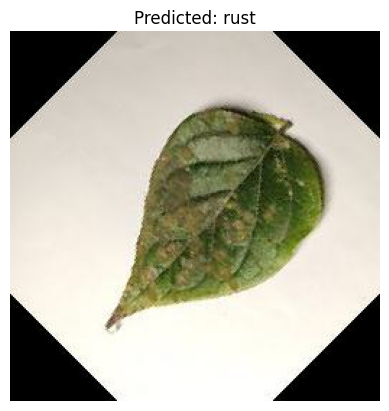

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_finetuned_on_boxed_leaves.h5')

# Set image parameters
img_size = 224
class_names = list(train_generator.class_indices.keys())  # Get class labels from training generator

# Function to preprocess and predict
def predict_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
predict_image('/content/image5.jpg')  # Replace with actual image path